# Database Searcher
## Find What you Want
### The First Step

This notebook searches the Cube Database stored locally on this machine and selects the cubes that meet a user-defined set of criteria. 

Currently, this notebook requires the Cube Database to be in .csv file formats with separate axes files. 

Can sift through the database for location, timme (via flyby number), and resolution limiters. 

A standard run is to find all cubes at a specific location or locaiton range at 25km resolution or lower. The location is usually what's important. 

In [1]:
#PARAMETER SETTING
#This is where you tell the program what restrictions it should have on its observations.

outputName = "oppositionGlobalList.csv" #Best to put ".csv" at the end of the name. 
#IF YOU DO NOT CHANGE THAT IT WILL OVERRIDE THE FILE WITH THIS NAME

#Set values you want to check to True.
latLonCheck = False #Restricting to specific location ranges
flybyCheck = False #Temporal restriction by flyby number
resolutionCheck = True #Restrict to a certain resolution classificaiton.
#If all of these are set to False you really don't need to run this notebook, as the AcceptableCubes.csv list will have what you want. 

#latLonCheck
#Bounds are not inclusive, this is to avoid edge case error values. (A point exactly at "0" is likely not real). 
latUpperBound = -7.0
latLowerBound = -12.0
lonUpperBound = 176.0
lonLowerBound = 166.0

#flybyCheck
flybyUpperBound = "T130" #This is NOT inclusive, the upper bound here will NOT be kept. 
flybyLowerBound = "T119" #This IS inclusive, the lower bound here WILL be kept. 
#Note: since this is the database search we can assume every cube exists, so we won't accidentially skip over something.

#resolutionCheck
#NOTE: cubes are given resolution values of the smallest nonzero resolution contained within their pixels
resUpperBound = 25.0 #25.0 is considered standard. 
resLowerBound = 0.0

oppositionCheck = True
#Wild and crazy new check: IS THE PIXEL WITHIN 5 DEGREES OF OPPOSITION? FIND OUT TODAY! 
#Opposition is just how close incidence and emission are to each other. We want them to be the same at 180 azimuth, more or less.
#math.acos(math.cos(INCI[j][i]*(np.pi/180))*math.cos(EMIS[j][i]*(np.pi/180))+math.sin(INCI[j][i]*(np.pi/180))*math.sin(EMIS[j][i]*(np.pi/180))*math.cos((180-AZIM[j][i])*(np.pi/180)))*(180/np.pi)

In [2]:
#SIFTER

#Imports
import csv
import math
import numpy as np
import scipy.misc

#Counter for our sanity, making sure the code hasn't gotten stuck and is progressing. 
counterForSanity = 0.0

#First, read in the data into a matrix. 
cubeList = []
with open('AcceptableCubes.csv') as csv_file:
    #AccpetableCubes.csv holds all the cubes deemed acceptable. 
    #All noodles and clear visual errors have been removed. 
    #If a new AcceptableCubes.csv needs to be generated, ceck the CubeDatabaseSearcher in SCRATCH WORK
    #Making an entirely new one is highly unlikely, though, at worst some of the higher number flybys will need to be manually added. 
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        paired = ["A","A"]
        paired[0] = row[0]
        paired[1] = row[1]
        cubeList.append(paired)
        line_count += 1

newCubeList = [] #The sorted cubes will go in here. 
#Now, for every item in cubeList, we find the file it poitns to and read it in. 
#Then we examine those files for *something*. Whatever it is. 

flybyRangeAcceptable = False

for item in cubeList:
    err = 0 #No error by default.

    if (flybyCheck == True): #Are we in the right flyby range?
        if (flybyLowerBound == item[0]):
            flybyRangeAcceptable = True
        elif (flybyUpperBound == item[0]): #Note that upper flyby bound is not inclusive. 
            flybyRangeAcceptable = False
    else: 
        flybyRangeAcceptable = True #If we're not checking for time, all of them are fine. 


    if (flybyRangeAcceptable == True): #Don't bother reading anything in if we don't want this flyby. 
        
        #This code is copy adapted from the VIMS Cube Visualisation Interface Notebook. 
        #It is complicated.
        #First, find the file. 
        filepath = "C:\\Users\\deran\\Desktop\\CubeCSVDatabase\\" + item[0] + "\\CM_" + item[1] + ".cub.csv"
    
        #Now we extract the axes file as well...
        cubeAxesfp = filepath.removesuffix(".csv") + ".axes.csv"
        
        #And grab the geo files. 
        cubeGeofpIR = filepath.removesuffix(".cub.csv") + "_ir_geo.cub.csv"
        cubeGeofpIRaxes = filepath.removesuffix(".cub.csv") + "_ir_geo.cub.axes.csv"
        
        #Skeleton code nabbed from https://realpython.com/python-csv/
    
        #Step 1: use the axes to determine the size of what we're dealing with.
        xAxisCube = []
        yAxisCube = []
        zAxisCube = []
        
        xAxisGeoIR = []
        yAxisGeoIR = []
        zAxisGeoIR = []
    
        try:
            with open(cubeAxesfp) as csv_file: #remember to tab.
                    csv_reader = csv.reader(csv_file, delimiter=',')
                    line_count = 0
                    for row in csv_reader:
                        i = 0
                        L = len(row)
                        while (i < L-1):
                            if (line_count == 0):
                                xAxisCube.append(row[i])
                            elif (line_count == 1):
                                yAxisCube.append(row[i])
                            elif (line_count == 2):
                                zAxisCube.append(row[i])
                            i = i+1
                        line_count += 1
        except:
            err = 1 #whoops.        
        try:
            with open(cubeGeofpIRaxes) as csv_file:
                csv_reader = csv.reader(csv_file, delimiter=',')
                line_count = 0
                for row in csv_reader:
                    i = 0
                    L = len(row)
                    while (i < L-1):
                        if (line_count == 0):
                            xAxisGeoIR.append(row[i])
                        elif (line_count == 1):
                            yAxisGeoIR.append(row[i])
                        elif (line_count == 2):
                            zAxisGeoIR.append(row[i])
                        i = i+1
                    line_count += 1
        except:
            err = 1 #whoops.
            
        #We now have an x, y, and z axis. x and y axes are just ordinal, but the z axis contains wavelength in microns.
        #The lengths of these arrays tell us how to extract the data.
        
        cubeData = [[[0 for x in range(len(zAxisCube))] for x in range(len(yAxisCube))] for x in range(len(xAxisCube))]
        geoIRData = [[[0 for x in range(len(zAxisGeoIR))] for x in range(len(yAxisGeoIR))] for x in range(len(xAxisGeoIR))]
        
        #The above holds the data of the cube itself. 
        try:
            with open(filepath) as csv_file:
                csv_reader = csv.reader(csv_file, delimiter=',')
                line_count = 0
                i, j, k = 0, 0, 0
                for row in csv_reader:
                    while (i < len(xAxisCube)):
                        cubeData[i][j][k] = float(row[i])
                        if (math.isnan(cubeData[i][j][k])):
                            cubeData[i][j][k] = 0 #We set nans to zero to allow plotting to take place, careful!
                        elif (cubeData[i][j][k] < 0):
                            cubeData[i][j][k] = 0 #Negative values are nonsense.
                        elif (cubeData[i][j][k] > 1):
                            cubeData[i][j][k] = 1 #Make saturation obvious? Keep it from overloading. 
                        i = i + 1
                    i = 0
                    j = j + 1
                    if (j >= len(yAxisCube)):
                        j = 0
                        k = k + 1
                    line_count += 1
        except:
            err = 1 #whoops.
        try:
            with open(cubeGeofpIR) as csv_file:
                csv_reader = csv.reader(csv_file, delimiter=',')
                line_count = 0
                i, j, k = 0, 0, 0
                for row in csv_reader:
                    while (i < len(xAxisGeoIR)):
                        geoIRData[i][j][k] = float(row[i])
                        if (math.isnan(geoIRData[i][j][k])):
                            geoIRData[i][j][k] = 0 #We set nans to zero to allow plotting to take place, careful!
                        elif (geoIRData[i][j][k] < -1000):
                            geoIRData[i][j][k] = 0 #The default value is an extremely negative number. Scrub it.
                        i = i + 1
                    i = 0
                    j = j + 1
                    if (j >= len(yAxisGeoIR)):
                        j = 0
                        k = k + 1
                    line_count += 1
        except:
            err = 1 #Whoops.
            
        #The data is now read in. 
        #Now we can do stuff with it.
        
        if (err == 0):
            i,j = 0,0
            bufferVal = 0.0
            locationFound = True
            oppositionFound = True
            if (resolutionCheck == True):
                bufferVal = resUpperBound+1 #Larger than the upper bound, always. 
            if (latLonCheck == True):
                locationFound = False #Can only fail to find a location if we're looking for one. 
            if (oppositionCheck == True):
                oppositionFound = False
            #If we're not checking resolution, keep this at zero, that means it will always pass. 
            if (resolutionCheck == True or latLonCheck == True): #only investigate pixels if necessary. 
                while (i < len(xAxisCube)):
                    j=0
                    while (j < len(yAxisCube)):
                        if (resolutionCheck == True): #Do we care about pixel resolution?
                            if (bufferVal > geoIRData[i][j][2] and geoIRData[i][j][2] != 0.0): #Resolutions of zero are errors, remove. 
                                bufferVal = geoIRData[i][j][2]
                        if (latLonCheck == True): #Do we care about pixel locaiton?
                            if (geoIRData[i][j][0] > latLowerBound and geoIRData[i][j][0] < latUpperBound and geoIRData[i][j][1] > lonLowerBound and geoIRData[i][j][1] < lonUpperBound):
                                locationFound = True
                        if (oppositionCheck == True): #Check viewing gometry for closeness to opposition. 
                            inci = geoIRData[i][j][5]
                            emis = geoIRData[i][j][6]
                            azim = 0.
                            #Azimuth formula from Jason Barnes' phasecurve.c++
                            p = geoIRData[i][j][4] #used to calculate azimuth.
                            ratio = -(np.cos(np.radians(p)) - np.cos(np.radians(inci))* np.cos(np.radians(emis)))/(np.sin(np.radians(inci))*np.sin(np.radians(emis)))
                            azim = np.arccos(ratio)
                            #Of course, this might be nan-ing. All the nans need their own values.
                            if((math.isnan(azim) == True) and (ratio>0.)):
                                azim = 0.
                            elif((math.isnan(azim) == True) and (ratio<0.)):
                                azim = 0.
                            elif((inci==0) and (emis==0)):
                                azim = 0.
                            elif(math.isnan(azim) == True):
                                print("Well you broke it, great. (Azimuth is nan, but could not be set to anything else.)")
                            if (inci < 0):
                                inci = 0
                            elif (inci > 100):
                                inci = 100
                            if (emis < 0):
                                emis = 0
                            elif (emis > 90):
                                emis = 90
                            if (azim < 0):
                                azim = 0
                            if (azim > 180):
                                azim = 180
                            if (math.acos(math.cos(inci*(np.pi/180))*math.cos(emis*(np.pi/180))+math.sin(inci*(np.pi/180))*math.sin(emis*(np.pi/180))*math.cos((azim)*(np.pi/180)))*(180/np.pi) < 5):
                                oppositionFound = True
                        j=j+1
                    i=i+1
            if (bufferVal <= resUpperBound and bufferVal >= resLowerBound): # Is resolution satisfactory?
                if (locationFound == True and oppositionFound == True): #Is the location we want in here somewhere?
                    newCubeList.append([item[0],item[1]]) #Only add if all criteria are met. 
                    print(item[0],item[1])
        else:
            print("Error on", item[0], item[1])
            
    if(counterForSanity%50 == 0): print(counterForSanity)
    counterForSanity = counterForSanity + 1

print(len(newCubeList))
print(newCubeList)

C:\Users\deran\AppData\Local\Temp\ipykernel_45068\98553922.py:7: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.3)
  import scipy.misc
C:\Users\deran\AppData\Local\Temp\ipykernel_45068\98553922.py:191: RuntimeWarning: invalid value encountered in scalar divide
  ratio = -(np.cos(np.radians(p)) - np.cos(np.radians(inci))* np.cos(np.radians(emis)))/(np.sin(np.radians(inci))*np.sin(np.radians(emis)))


0.0


C:\Users\deran\AppData\Local\Temp\ipykernel_45068\98553922.py:192: RuntimeWarning: invalid value encountered in arccos
  azim = np.arccos(ratio)


50.0
TA 1477488820_1
TA 1477489741_1
TA 1477489943_1
TA 1477490280_1
100.0
TA 1477490431_1
TA 1477490625_1
TA 1477491859_1
150.0
TB 1481616614_1
TB 1481616786_1
TB 1481617040_1
TB 1481617259_1
TB 1481617473_1
TB 1481617709_1
TB 1481617957_1
TB 1481618188_1
TB 1481618418_1
TB 1481618592_1
TB 1481618830_1
TB 1481619484_1
TB 1481619743_1
200.0
TB 1481623711_1
TB 1481623853_1
TB 1481624032_1
TB 1481624171_1
TB 1481624349_1
TB 1481624482_1
TB 1481624672_1
TB 1481624812_1
TB 1481624991_1
TB 1481625137_1
TB 1481625558_1
TB 1481625703_1
TB 1481625847_1
TB 1481625997_1
TB 1481626515_1
TB 1481626725_1
TB 1481626923_1
TB 1481627074_1
TB 1481634623_1
TB 1481637048_1
250.0
300.0
350.0
400.0
450.0
500.0
T5 1492366621_1
T5 1492367246_3
T6 1503389227_1
T6 1503398325_1
T6 1503400912_3
550.0
600.0
650.0
700.0
750.0
800.0
T9 1514299908_1
T9 1514299938_1
T9 1514300036_1
T9 1514300105_1
T9 1514300683_1
T9 1514300850_1
T9 1514301073_1
T9 1514301240_1
T9 1514301398_1
T9 1514301428_1
T9 1514301526_1
T9 151430

C:\Users\deran\AppData\Local\Temp\ipykernel_45068\98553922.py:191: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = -(np.cos(np.radians(p)) - np.cos(np.radians(inci))* np.cos(np.radians(emis)))/(np.sin(np.radians(inci))*np.sin(np.radians(emis)))


T44 1590648776_1
T44 1590648938_1
Error on T44 1590677166_1
Error on T44 1590677655_1
Error on T44 1590678142_1
Error on T44 1590678623_1
Error on T44 1590679103_1
Error on T44 1590679590_1
Error on T44 1590680074_1
Error on T44 1590680553_1
Error on T44 1590680877_1
Error on T44 1590681367_1
Error on T44 1590681848_1
Error on T44 1590682326_1
Error on T44 1590682823_1
Error on T44 1590683303_1
Error on T44 1590683787_1
Error on T44 1590683949_1
Error on T44 1590684265_1
Error on T44 1590684428_1
Error on T44 1590684750_1
Error on T44 1590684912_1
Error on T44 1590685395_1
Error on T44 1590685880_1
Error on T44 1590686196_1
Error on T44 1590686359_1
Error on T44 1590687565_1
4900.0
Error on T44 1590704363_1
Error on T44 1590728835_1
Error on T44 1590730498_1
Error on T44 1590749064_1
4950.0
Error on T44 1590751622_1
Error on T45 1596098934_1
Error on T45 1596099012_1
Error on T45 1596099089_1
Error on T45 1596099166_1
Error on T45 1596099244_1
Error on T45 1596099321_1
Error on T45 159

In [3]:
#This cell saves the list. Remember to set the name of the file in the first cell.
#WILL OVERWRITE ANY FILE WITH THE SAME outputName
with open(outputName, 'w') as dataEntry: #w for write
    i,j,k = 0,0,0 #Iterators for the other lists.
    for item in newCubeList:
        dataEntry.write(str(item[0]) + "," + str(item[1]) + "," + "\n")

# SPECIALTY CODE

## DO NOT RUN UNLESS YOU ARE ME, GM

### HELLO SELF! HOW ARE YA?

In [1]:
#SPECIALTY CODE
#Need to create an ANNOTATED Acceptable Cubes list, so we can create a wholly VIMS Titan Mask later.

#PARAMETER SETTING
#This is where you tell the program what restrictions it should have on its observations.

outputName = "acceptableCubesAnnotated.csv" #Best to put ".csv" at the end of the name. 
#IF YOU DO NOT CHANGE THAT IT WILL OVERRIDE THE FILE WITH THIS NAME

#Set values you want to check to True.
latLonCheck = False #Restricting to specific location ranges
flybyCheck = False #Temporal restriction by flyby number
resolutionCheck = False #Restrict to a certain resolution classificaiton.
#If all of these are set to False you really don't need to run this notebook, as the AcceptableCubes.csv list will have what you want. 
#Except for this SPECIAL CODE where I perform the AcceptableCubes DATABASE SEARCH to ANNOTATE THEM with WHICH LOCATIONS THEY ARE SUITABLE FOR.

#latLonCheck
#Bounds are not inclusive, this is to avoid edge case error values. (A point exactly at "0" is likely not real). 
latUpperBound = 30.0
latLowerBound = -30.0
lonUpperBound = 360.0
lonLowerBound = 0.0

#flybyCheck
flybyUpperBound = "T130" #This is NOT inclusive, the upper bound here will NOT be kept. 
flybyLowerBound = "T119" #This IS inclusive, the lower bound here WILL be kept. 
#Note: since this is the database search we can assume every cube exists, so we won't accidentially skip over something.

#resolutionCheck
#NOTE: cubes are given resolution values of the smallest nonzero resolution contained within their pixels
resUpperBound = 50.0 #25.0 is considered standard. 
resLowerBound = 0.0

In [16]:
#SIFTER

#Imports
import csv
import math
import numpy as np
import scipy.misc

#Counter for our sanity, making sure the code hasn't gotten stuck and is progressing. 
counterForSanity = 0.0

#First, read in the data into a matrix. 
cubeList = []
with open('AcceptableCubes.csv') as csv_file:
    #AccpetableCubes.csv holds all the cubes deemed acceptable. 
    #All noodles and clear visual errors have been removed. 
    #If a new AcceptableCubes.csv needs to be generated, ceck the CubeDatabaseSearcher in SCRATCH WORK
    #Making an entirely new one is highly unlikely, though, at worst some of the higher number flybys will need to be manually added. 
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        paired = ["A","A"]
        paired[0] = row[0]
        paired[1] = row[1]
        cubeList.append(paired)
        line_count += 1

newCubeList = [] #The sorted cubes will go in here. With all the extra data.
#Now, for every item in cubeList, we find the file it poitns to and read it in. 
#Then we examine those files for *something*. Whatever it is. 

flybyRangeAcceptable = False

for item in cubeList:
    err = 0 #No error by default.

    #No need to waste time with checks, we ARE looking at every cube.
        
    #This code is copy adapted from the VIMS Cube Visualisation Interface Notebook. 
    #It is complicated.
    #First, find the file. 
    filepath = "C:\\Users\\deran\\Desktop\\CubeCSVDatabase\\" + item[0] + "\\CM_" + item[1] + ".cub.csv"

    #Now we extract the axes file as well...
    cubeAxesfp = filepath.removesuffix(".csv") + ".axes.csv"
    
    #And grab the geo files. 
    cubeGeofpIR = filepath.removesuffix(".cub.csv") + "_ir_geo.cub.csv"
    cubeGeofpIRaxes = filepath.removesuffix(".cub.csv") + "_ir_geo.cub.axes.csv"
    
    #Skeleton code nabbed from https://realpython.com/python-csv/

    #Step 1: use the axes to determine the size of what we're dealing with.
    xAxisCube = []
    yAxisCube = []
    zAxisCube = []
    
    xAxisGeoIR = []
    yAxisGeoIR = []
    zAxisGeoIR = []

    try:
        with open(cubeAxesfp) as csv_file: #remember to tab.
                csv_reader = csv.reader(csv_file, delimiter=',')
                line_count = 0
                for row in csv_reader:
                    i = 0
                    L = len(row)
                    while (i < L-1):
                        if (line_count == 0):
                            xAxisCube.append(row[i])
                        elif (line_count == 1):
                            yAxisCube.append(row[i])
                        elif (line_count == 2):
                            zAxisCube.append(row[i])
                        i = i+1
                    line_count += 1
    except:
        err = 1 #whoops.        
    try:
        with open(cubeGeofpIRaxes) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            line_count = 0
            for row in csv_reader:
                i = 0
                L = len(row)
                while (i < L-1):
                    if (line_count == 0):
                        xAxisGeoIR.append(row[i])
                    elif (line_count == 1):
                        yAxisGeoIR.append(row[i])
                    elif (line_count == 2):
                        zAxisGeoIR.append(row[i])
                    i = i+1
                line_count += 1
    except:
        err = 1 #whoops.
        
    #We now have an x, y, and z axis. x and y axes are just ordinal, but the z axis contains wavelength in microns.
    #The lengths of these arrays tell us how to extract the data.
    
    cubeData = [[[0 for x in range(len(zAxisCube))] for x in range(len(yAxisCube))] for x in range(len(xAxisCube))]
    geoIRData = [[[0 for x in range(len(zAxisGeoIR))] for x in range(len(yAxisGeoIR))] for x in range(len(xAxisGeoIR))]
    
    #The above holds the data of the cube itself. 
    try:
        with open(filepath) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            line_count = 0
            i, j, k = 0, 0, 0
            for row in csv_reader:
                while (i < len(xAxisCube)):
                    cubeData[i][j][k] = float(row[i])
                    if (math.isnan(cubeData[i][j][k])):
                        cubeData[i][j][k] = 0 #We set nans to zero to allow plotting to take place, careful!
                    elif (cubeData[i][j][k] < 0):
                        cubeData[i][j][k] = 0 #Negative values are nonsense.
                    elif (cubeData[i][j][k] > 1):
                        cubeData[i][j][k] = 1 #Make saturation obvious? Keep it from overloading. 
                    i = i + 1
                i = 0
                j = j + 1
                if (j >= len(yAxisCube)):
                    j = 0
                    k = k + 1
                line_count += 1
    except:
        err = 1 #whoops.
    try:
        with open(cubeGeofpIR) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            line_count = 0
            i, j, k = 0, 0, 0
            for row in csv_reader:
                while (i < len(xAxisGeoIR)):
                    geoIRData[i][j][k] = float(row[i])
                    if (math.isnan(geoIRData[i][j][k])):
                        geoIRData[i][j][k] = 0 #We set nans to zero to allow plotting to take place, careful!
                    elif (geoIRData[i][j][k] < -1000):
                        geoIRData[i][j][k] = 0 #The default value is an extremely negative number. Scrub it.
                    i = i + 1
                i = 0
                j = j + 1
                if (j >= len(yAxisGeoIR)):
                    j = 0
                    k = k + 1
                line_count += 1
    except:
        err = 1 #Whoops.
        
    #The data is now read in. 
    #Now we can do stuff with it.

    #What we need to do is append to each cube a list of locations it contains that have resolutions 45km or below.
    #This will be accomplished by adding a series of four numbers. The actual new file will have entries like:
    #FLYBY, CUBE, LAT1, LON1, MINRES1, MAXRES1, LAT2, LON2, MINRES2, MASRES2, LAT3... 
    #Essentially a list of all lats and lons (integers) included, and the range of resolutions on them.
    
    
    if (err == 0):

        locationIndex = [] #Holds pairs of lat and lon for ease of searching and comparison.
        resIndex = [] #holds pairs of minres and maxres for each location pair.
        acceptableIndex = [] #Holds arrays of lat, lon, minres, maxres. Will be compiled at the end before being added to the newCubeList.
        globalMinRes = 50
        globalMaxRes = 0
        
        i,j = 0,0
        bufferVal = 0.0
        while (i < len(xAxisCube)):
            j=0
            while (j < len(yAxisCube)):

                lat = np.round(geoIRData[i][j][0]/1.)
                lon = np.round(geoIRData[i][j][1]/1.)
                res = geoIRData[i][j][2]

                if (res <= 45.0 and res!= 0.0): #This is the largest resolution we could ever conceivably want to use. 
                    #About the arc length of one degree of latitude.
                    #As longitude gets unreasonably small at the poles we use latitude.

                    #Keep track of the "quality" of our cube here, will make it easier to sift through later.
                    if (res < globalMinRes):
                        globalMinRes = res
                    if (res > globalMaxRes):
                        globalMaxRes = res
                    
                    if (len(locationIndex) == 0):
                        locationIndex.append([lat,lon]) #If no points are here, add this one.
                        resIndex.append([res,res]) #The initial resolution is both the min and the max.
                    else:
                        if ([lat,lon] in locationIndex): #NEED TO FIND THE POSITION OF THIS PAIR IN THE LIST SO WE CAN ASSIGN RES CORRECTLY.
                            coordinate = locationIndex.index([lat,lon])
                            if (res < resIndex[coordinate][0]):
                                resIndex[coordinate][0] = res
                            elif (res > resIndex[coordinate][1]):
                                resIndex[coordinate][1] = res
                        else:
                            locationIndex.append([lat,lon]) #If no points are here, add this one.
                            resIndex.append([res,res]) #The initial resolution is both the min and the max.

                j=j+1
            i=i+1

        if (len(locationIndex) >= 1): #Conglomerate our information together into one array.
            p = 0
            for pair in locationIndex:
                acceptableIndex.append([int(pair[0]),int(pair[1]),float(resIndex[p][0]),float(resIndex[p][1])])
                p=p+1
        
        if (len(acceptableIndex) >= 1): # Do we HAVE any satisfactory locations?

            #APPEND TO THE FILE!
            with open(outputName, 'a') as dataEntry: #w for write
                dataEntry.write(str(item[0]) + "," + str(item[1]) + "," + str(globalMinRes) + "," + str(globalMaxRes) + "," + str(acceptableIndex) + "," + "\n")
                #May need to manually remove [] characters later, but that's fine. Search n replace!
    else:
        print("Error on", item[0], item[1])
            
    if(counterForSanity%25 == 0): print(counterForSanity, "/17040", str((counterForSanity/17040.0)*100) + "%")
    counterForSanity = counterForSanity + 1

print(len(newCubeList))
print(newCubeList)

0.0 /17040 0.0%
25.0 /17040 0.14671361502347416%
50.0 /17040 0.2934272300469483%
75.0 /17040 0.44014084507042256%
100.0 /17040 0.5868544600938966%
125.0 /17040 0.7335680751173709%
150.0 /17040 0.8802816901408451%
175.0 /17040 1.0269953051643192%
200.0 /17040 1.1737089201877933%
225.0 /17040 1.3204225352112675%
250.0 /17040 1.4671361502347418%
275.0 /17040 1.613849765258216%
300.0 /17040 1.7605633802816902%
325.0 /17040 1.9072769953051645%
350.0 /17040 2.0539906103286385%
375.0 /17040 2.2007042253521125%
400.0 /17040 2.3474178403755865%
425.0 /17040 2.494131455399061%
450.0 /17040 2.640845070422535%
475.0 /17040 2.7875586854460095%
500.0 /17040 2.9342723004694835%
525.0 /17040 3.080985915492958%
550.0 /17040 3.227699530516432%
575.0 /17040 3.374413145539906%
600.0 /17040 3.5211267605633805%
625.0 /17040 3.6678403755868545%
650.0 /17040 3.814553990610329%
675.0 /17040 3.961267605633803%
700.0 /17040 4.107981220657277%
725.0 /17040 4.254694835680752%
750.0 /17040 4.401408450704225%
775.0 

In [1]:
#Now we can read in what we just created over... looks like about six hours. 
#3624 cubes passed the test. Likely because we took a lot at super far distances, or has a bunch of invalid "0" resolution cubes. 
#Read in the file, sort everything into the needed arrays, and then display NUMBER OF CUBES and BEST RESOLUTION maps of Titan.
import matplotlib.pyplot as plt
import csv
import math
import numpy as np
import scipy.misc

cubeList = 'acceptableCubesAnnotated.csv' #Insert file name for SIMULATION DATA here.

cubeNum45 = [[0 for x in range(360)] for x in range(181)]
cubeNum25 = [[0 for x in range(360)] for x in range(181)]
cubeNum15 = [[0 for x in range(360)] for x in range(181)]
cubeNum10 = [[0 for x in range(360)] for x in range(181)]
bestRes = [[46 for x in range(360)] for x in range(181)]


with open(cubeList) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        edgeSafeguard = [] #So it turns out we can double count the 0/360 edge. This lets us not do that.
        size = len(row) #each row is a cube which may look at several locaitons.
        loc = 1 #The "0" location is just the cube as a whole metadata, which we do not care about.
        while (loc < (size-1)/4): #-1 since there is an extra hanging comma at the end of the line.
            lat = int(row[loc*4])
            lon = int(row[loc*4+1])
            if (lon == 0): lon = 360 #these are the same index. Set to 360 so that when we flip it ends up on index 0.
            minRes = float(row[loc*4+2])
            maxRes = float(row[loc*4+3]) #We actually don't care about this one but might as well read it in anyway.
            if (lat <= 90 and lat >= -90 and lon <= 360 and lon >= 1 and not ([lat,lon] in edgeSafeguard)): #No exterior ones allowed! Most assuredly errors!
                cubeNum45[90-lat][360-lon] = cubeNum45[90-lat][360-lon] + 1
                if (minRes <= 10):
                    cubeNum10[90-lat][360-lon] = cubeNum10[90-lat][360-lon] + 1
                if (minRes <= 15):
                    cubeNum15[90-lat][360-lon] = cubeNum15[90-lat][360-lon] + 1
                if (minRes <= 25):
                    cubeNum25[90-lat][360-lon] = cubeNum25[90-lat][360-lon] + 1
                if (bestRes[90-lat][360-lon] > minRes):
                    bestRes[90-lat][360-lon] = minRes #Confusing that minRes is bestRes but the number IS smaller...
                    #Just make sure to keep it consistent.
                if (lon == 360): edgeSafeguard.append([lat,lon]) #Don't count the edge twice per cube, that's silly.
            loc = loc+1
        line_count += 1

#plt.savefig("TitanSurfaceMask.pdf", format="pdf", bbox_inches='tight')

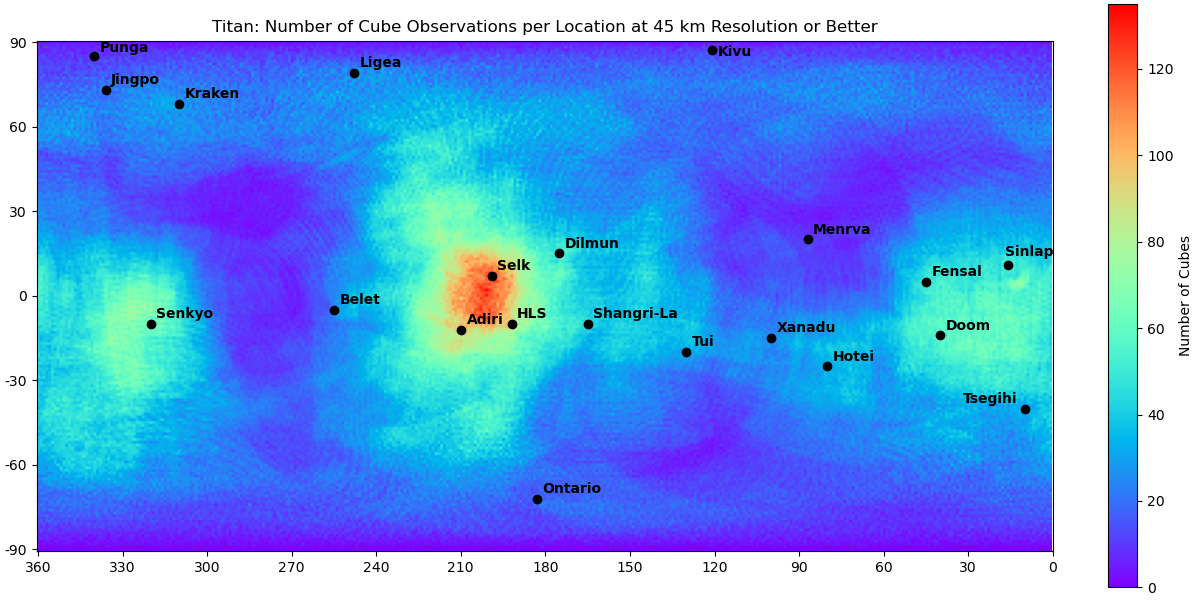

In [2]:
%matplotlib ipympl 

fig, ax = plt.subplots(figsize = (12,6),layout="constrained")
image = ax.imshow(cubeNum45, cmap = "rainbow")
cb = plt.colorbar(image, label = "Number of Cubes")

plt.scatter(360-192, 90+10,color="black")
plt.text(360-192+2, 90+10-2, "HLS", color="black", weight="bold")

plt.scatter(360-183, 90+72,color="black")
plt.text(360-183+2, 90+72-2, "Ontario", color="black", weight="bold")

plt.scatter(360-16, 90-11,color="black")
plt.text(360-16-1, 90-11-3, "Sinlap", color="black", weight="bold")

plt.scatter(360-310, 90-68,color="black")
plt.text(360-310+2, 90-68-2, "Kraken", color="black", weight="bold")

plt.scatter(360-248, 90-79,color="black")
plt.text(360-248+2, 90-79-2, "Ligea", color="black", weight="bold")

plt.scatter(360-340, 90-85,color="black")
plt.text(360-340+2, 90-85-1.6, "Punga", color="black", weight="bold")

plt.scatter(360-336, 90-73,color="black")
plt.text(360-336+2, 90-73-2, "Jingpo", color="black", weight="bold")

plt.scatter(360-121, 90-87,color="black")
plt.text(360-121+2, 90-87+2, "Kivu", color="black", weight="bold")

plt.scatter(360-87, 90-20,color="black")
plt.text(360-87+2, 90-20-2, "Menrva", color="black", weight="bold")

plt.scatter(360-199, 90-7,color="black")
plt.text(360-199+2, 90-7-2, "Selk", color="black", weight="bold")

plt.scatter(360-165, 90+10,color="black")
plt.text(360-165+2, 90+10-2, "Shangri-La", color="black", weight="bold")

plt.scatter(360-10, 90+40,color="black")
plt.text(360-10-22, 90+40-2, "Tsegihi", color="black", weight="bold")

plt.scatter(360-40, 90+14,color="black")
plt.text(360-40+2, 90+14-2, "Doom", color="black", weight="bold")

plt.scatter(360-210, 90+12,color="black")
plt.text(360-210+2, 90+12-2, "Adiri", color="black", weight="bold")

plt.scatter(360-175, 90-15,color="black")
plt.text(360-175+2, 90-15-2, "Dilmun", color="black", weight="bold")

plt.scatter(360-255, 90+5,color="black")
plt.text(360-255+2, 90+5-2, "Belet", color="black", weight="bold")

plt.scatter(360-320, 90+10,color="black")
plt.text(360-320+2, 90+10-2, "Senkyo", color="black", weight="bold")

plt.scatter(360-45, 90-5,color="black")
plt.text(360-45+2, 90-5-2, "Fensal", color="black", weight="bold")

plt.scatter(360-100, 90+15,color="black")
plt.text(360-100+2, 90+15-2, "Xanadu", color="black", weight="bold")

plt.scatter(360-130, 90+20,color="black")
plt.text(360-130+2, 90+20-2, "Tui", color="black", weight="bold")

plt.scatter(360-80, 90+25,color="black")
plt.text(360-80+2, 90+25-2, "Hotei", color="black", weight="bold")

latTicks = [0, 30, 60, 90, 120, 150, 180]
latLabels = ["90", "60", "30", "0", "-30", "-60", "-90"]
lonTicks = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
lonLabels = ["360", "330", "300", "270", "240", "210", "180", "150", "120", "90", "60", "30", "0"]
ax.set_yticks(latTicks)
ax.set_yticklabels(latLabels)
ax.set_xticks(lonTicks)
ax.set_xticklabels(lonLabels)
ax.set(title = "Titan: Number of Cube Observations per Location at 45 km Resolution or Better")

plt.savefig("CubeNum45.pdf", format="pdf")

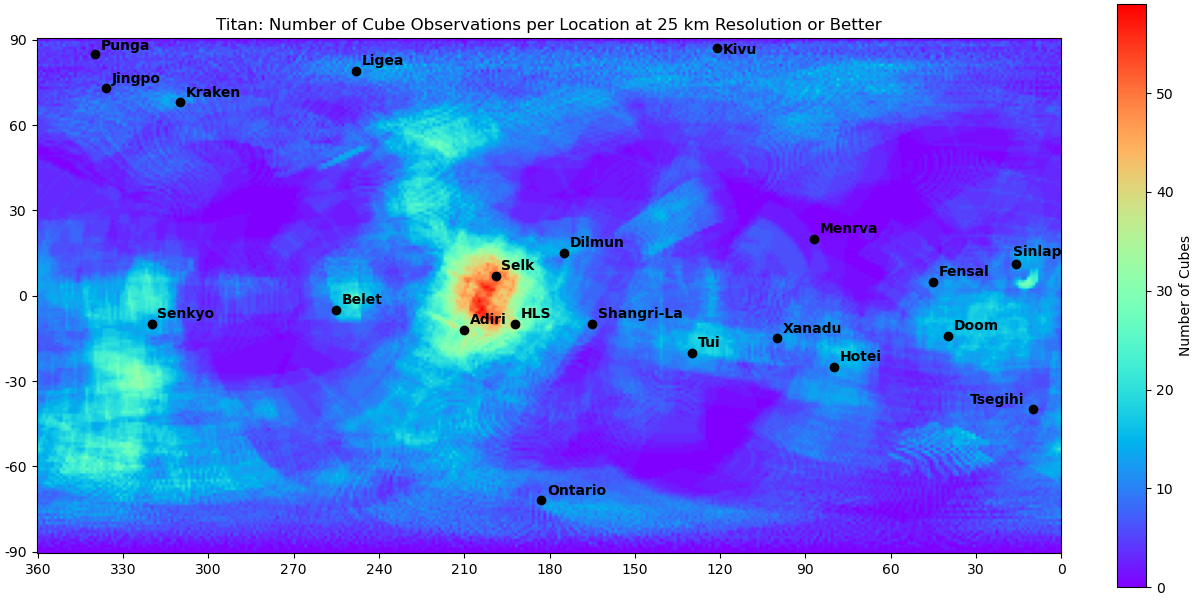

In [3]:
%matplotlib ipympl 

fig, ax = plt.subplots(figsize = (12,6),layout="constrained")
image = ax.imshow(cubeNum25, cmap = "rainbow")
cb = plt.colorbar(image, label = "Number of Cubes")

plt.scatter(360-192, 90+10,color="black")
plt.text(360-192+2, 90+10-2, "HLS", color="black", weight="bold")

plt.scatter(360-183, 90+72,color="black")
plt.text(360-183+2, 90+72-2, "Ontario", color="black", weight="bold")

plt.scatter(360-16, 90-11,color="black")
plt.text(360-16-1, 90-11-3, "Sinlap", color="black", weight="bold")

plt.scatter(360-310, 90-68,color="black")
plt.text(360-310+2, 90-68-2, "Kraken", color="black", weight="bold")

plt.scatter(360-248, 90-79,color="black")
plt.text(360-248+2, 90-79-2, "Ligea", color="black", weight="bold")

plt.scatter(360-340, 90-85,color="black")
plt.text(360-340+2, 90-85-1.6, "Punga", color="black", weight="bold")

plt.scatter(360-336, 90-73,color="black")
plt.text(360-336+2, 90-73-2, "Jingpo", color="black", weight="bold")

plt.scatter(360-121, 90-87,color="black")
plt.text(360-121+2, 90-87+2, "Kivu", color="black", weight="bold")

plt.scatter(360-87, 90-20,color="black")
plt.text(360-87+2, 90-20-2, "Menrva", color="black", weight="bold")

plt.scatter(360-199, 90-7,color="black")
plt.text(360-199+2, 90-7-2, "Selk", color="black", weight="bold")

plt.scatter(360-165, 90+10,color="black")
plt.text(360-165+2, 90+10-2, "Shangri-La", color="black", weight="bold")

plt.scatter(360-10, 90+40,color="black")
plt.text(360-10-22, 90+40-2, "Tsegihi", color="black", weight="bold")

plt.scatter(360-40, 90+14,color="black")
plt.text(360-40+2, 90+14-2, "Doom", color="black", weight="bold")

plt.scatter(360-210, 90+12,color="black")
plt.text(360-210+2, 90+12-2, "Adiri", color="black", weight="bold")

plt.scatter(360-175, 90-15,color="black")
plt.text(360-175+2, 90-15-2, "Dilmun", color="black", weight="bold")

plt.scatter(360-255, 90+5,color="black")
plt.text(360-255+2, 90+5-2, "Belet", color="black", weight="bold")

plt.scatter(360-320, 90+10,color="black")
plt.text(360-320+2, 90+10-2, "Senkyo", color="black", weight="bold")

plt.scatter(360-45, 90-5,color="black")
plt.text(360-45+2, 90-5-2, "Fensal", color="black", weight="bold")

plt.scatter(360-100, 90+15,color="black")
plt.text(360-100+2, 90+15-2, "Xanadu", color="black", weight="bold")

plt.scatter(360-130, 90+20,color="black")
plt.text(360-130+2, 90+20-2, "Tui", color="black", weight="bold")

plt.scatter(360-80, 90+25,color="black")
plt.text(360-80+2, 90+25-2, "Hotei", color="black", weight="bold")

latTicks = [0, 30, 60, 90, 120, 150, 180]
latLabels = ["90", "60", "30", "0", "-30", "-60", "-90"]
lonTicks = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
lonLabels = ["360", "330", "300", "270", "240", "210", "180", "150", "120", "90", "60", "30", "0"]
ax.set_yticks(latTicks)
ax.set_yticklabels(latLabels)
ax.set_xticks(lonTicks)
ax.set_xticklabels(lonLabels)
ax.set(title = "Titan: Number of Cube Observations per Location at 25 km Resolution or Better")

plt.savefig("CubeNum25.pdf", format="pdf")

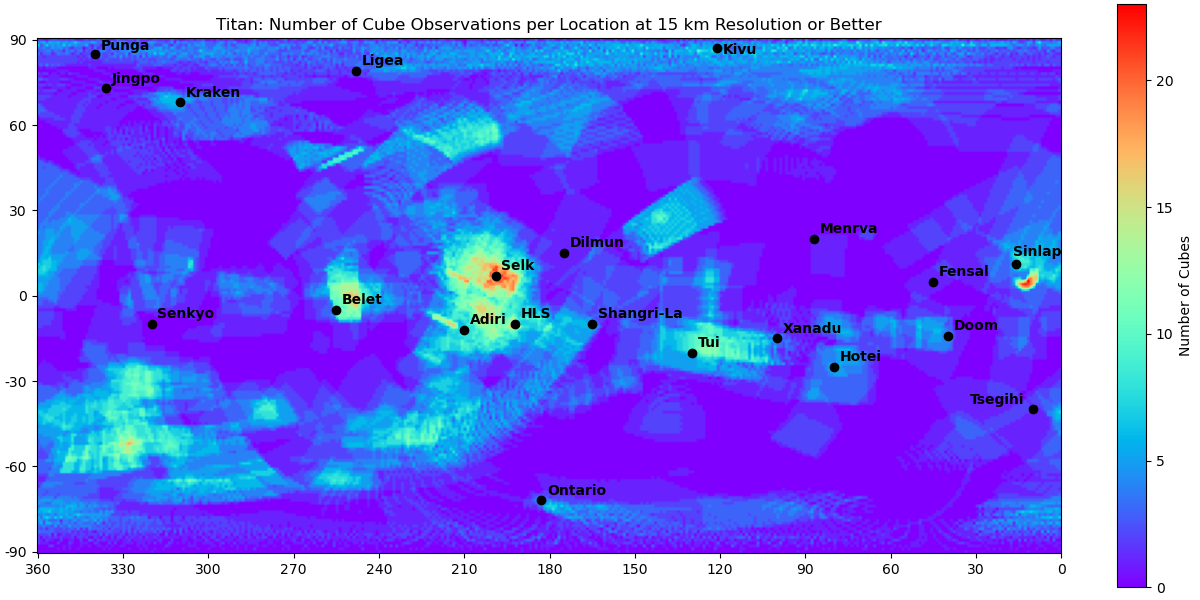

In [4]:
%matplotlib ipympl 

fig, ax = plt.subplots(figsize = (12,6),layout="constrained")
image = ax.imshow(cubeNum15, cmap = "rainbow")
cb = plt.colorbar(image, label = "Number of Cubes")

plt.scatter(360-192, 90+10,color="black")
plt.text(360-192+2, 90+10-2, "HLS", color="black", weight="bold")

plt.scatter(360-183, 90+72,color="black")
plt.text(360-183+2, 90+72-2, "Ontario", color="black", weight="bold")

plt.scatter(360-16, 90-11,color="black")
plt.text(360-16-1, 90-11-3, "Sinlap", color="black", weight="bold")

plt.scatter(360-310, 90-68,color="black")
plt.text(360-310+2, 90-68-2, "Kraken", color="black", weight="bold")

plt.scatter(360-248, 90-79,color="black")
plt.text(360-248+2, 90-79-2, "Ligea", color="black", weight="bold")

plt.scatter(360-340, 90-85,color="black")
plt.text(360-340+2, 90-85-1.6, "Punga", color="black", weight="bold")

plt.scatter(360-336, 90-73,color="black")
plt.text(360-336+2, 90-73-2, "Jingpo", color="black", weight="bold")

plt.scatter(360-121, 90-87,color="black")
plt.text(360-121+2, 90-87+2, "Kivu", color="black", weight="bold")

plt.scatter(360-87, 90-20,color="black")
plt.text(360-87+2, 90-20-2, "Menrva", color="black", weight="bold")

plt.scatter(360-199, 90-7,color="black")
plt.text(360-199+2, 90-7-2, "Selk", color="black", weight="bold")

plt.scatter(360-165, 90+10,color="black")
plt.text(360-165+2, 90+10-2, "Shangri-La", color="black", weight="bold")

plt.scatter(360-10, 90+40,color="black")
plt.text(360-10-22, 90+40-2, "Tsegihi", color="black", weight="bold")

plt.scatter(360-40, 90+14,color="black")
plt.text(360-40+2, 90+14-2, "Doom", color="black", weight="bold")

plt.scatter(360-210, 90+12,color="black")
plt.text(360-210+2, 90+12-2, "Adiri", color="black", weight="bold")

plt.scatter(360-175, 90-15,color="black")
plt.text(360-175+2, 90-15-2, "Dilmun", color="black", weight="bold")

plt.scatter(360-255, 90+5,color="black")
plt.text(360-255+2, 90+5-2, "Belet", color="black", weight="bold")

plt.scatter(360-320, 90+10,color="black")
plt.text(360-320+2, 90+10-2, "Senkyo", color="black", weight="bold")

plt.scatter(360-45, 90-5,color="black")
plt.text(360-45+2, 90-5-2, "Fensal", color="black", weight="bold")

plt.scatter(360-100, 90+15,color="black")
plt.text(360-100+2, 90+15-2, "Xanadu", color="black", weight="bold")

plt.scatter(360-130, 90+20,color="black")
plt.text(360-130+2, 90+20-2, "Tui", color="black", weight="bold")

plt.scatter(360-80, 90+25,color="black")
plt.text(360-80+2, 90+25-2, "Hotei", color="black", weight="bold")

latTicks = [0, 30, 60, 90, 120, 150, 180]
latLabels = ["90", "60", "30", "0", "-30", "-60", "-90"]
lonTicks = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
lonLabels = ["360", "330", "300", "270", "240", "210", "180", "150", "120", "90", "60", "30", "0"]
ax.set_yticks(latTicks)
ax.set_yticklabels(latLabels)
ax.set_xticks(lonTicks)
ax.set_xticklabels(lonLabels)
ax.set(title = "Titan: Number of Cube Observations per Location at 15 km Resolution or Better")

plt.savefig("CubeNum15.pdf", format="pdf")

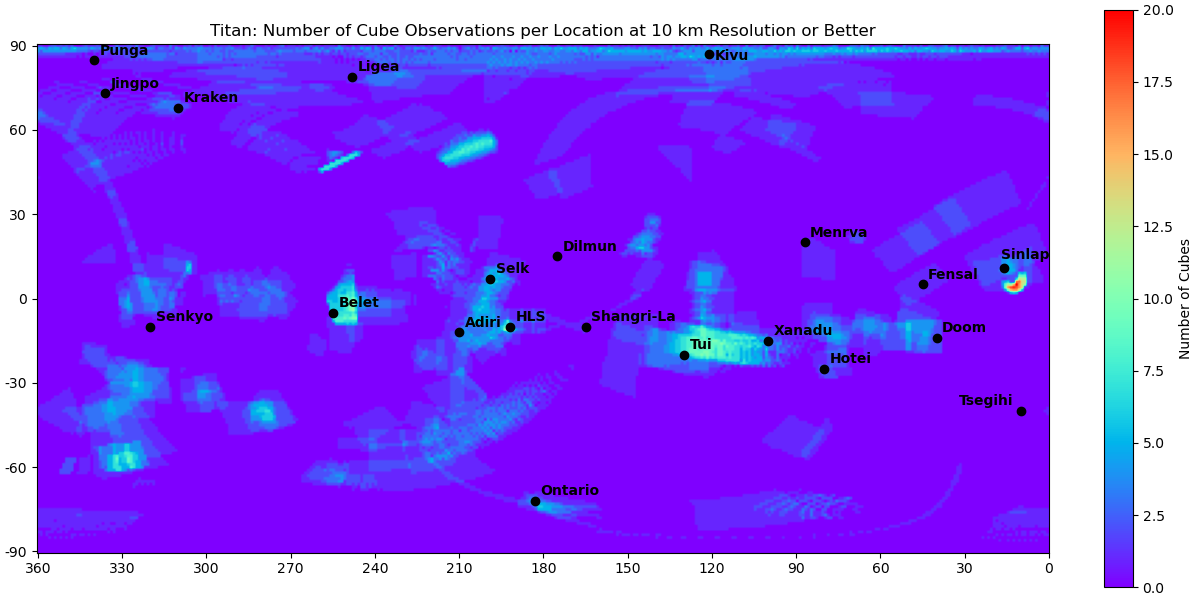

In [5]:
%matplotlib ipympl 

fig, ax = plt.subplots(figsize = (12,6),layout="constrained")
image = ax.imshow(cubeNum10, cmap = "rainbow")
cb = plt.colorbar(image, label = "Number of Cubes")

plt.scatter(360-192, 90+10,color="black")
plt.text(360-192+2, 90+10-2, "HLS", color="black", weight="bold")

plt.scatter(360-183, 90+72,color="black")
plt.text(360-183+2, 90+72-2, "Ontario", color="black", weight="bold")

plt.scatter(360-16, 90-11,color="black")
plt.text(360-16-1, 90-11-3, "Sinlap", color="black", weight="bold")

plt.scatter(360-310, 90-68,color="black")
plt.text(360-310+2, 90-68-2, "Kraken", color="black", weight="bold")

plt.scatter(360-248, 90-79,color="black")
plt.text(360-248+2, 90-79-2, "Ligea", color="black", weight="bold")

plt.scatter(360-340, 90-85,color="black")
plt.text(360-340+2, 90-85-1.6, "Punga", color="black", weight="bold")

plt.scatter(360-336, 90-73,color="black")
plt.text(360-336+2, 90-73-2, "Jingpo", color="black", weight="bold")

plt.scatter(360-121, 90-87,color="black")
plt.text(360-121+2, 90-87+2, "Kivu", color="black", weight="bold")

plt.scatter(360-87, 90-20,color="black")
plt.text(360-87+2, 90-20-2, "Menrva", color="black", weight="bold")

plt.scatter(360-199, 90-7,color="black")
plt.text(360-199+2, 90-7-2, "Selk", color="black", weight="bold")

plt.scatter(360-165, 90+10,color="black")
plt.text(360-165+2, 90+10-2, "Shangri-La", color="black", weight="bold")

plt.scatter(360-10, 90+40,color="black")
plt.text(360-10-22, 90+40-2, "Tsegihi", color="black", weight="bold")

plt.scatter(360-40, 90+14,color="black")
plt.text(360-40+2, 90+14-2, "Doom", color="black", weight="bold")

plt.scatter(360-210, 90+12,color="black")
plt.text(360-210+2, 90+12-2, "Adiri", color="black", weight="bold")

plt.scatter(360-175, 90-15,color="black")
plt.text(360-175+2, 90-15-2, "Dilmun", color="black", weight="bold")

plt.scatter(360-255, 90+5,color="black")
plt.text(360-255+2, 90+5-2, "Belet", color="black", weight="bold")

plt.scatter(360-320, 90+10,color="black")
plt.text(360-320+2, 90+10-2, "Senkyo", color="black", weight="bold")

plt.scatter(360-45, 90-5,color="black")
plt.text(360-45+2, 90-5-2, "Fensal", color="black", weight="bold")

plt.scatter(360-100, 90+15,color="black")
plt.text(360-100+2, 90+15-2, "Xanadu", color="black", weight="bold")

plt.scatter(360-130, 90+20,color="black")
plt.text(360-130+2, 90+20-2, "Tui", color="black", weight="bold")

plt.scatter(360-80, 90+25,color="black")
plt.text(360-80+2, 90+25-2, "Hotei", color="black", weight="bold")

latTicks = [0, 30, 60, 90, 120, 150, 180]
latLabels = ["90", "60", "30", "0", "-30", "-60", "-90"]
lonTicks = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
lonLabels = ["360", "330", "300", "270", "240", "210", "180", "150", "120", "90", "60", "30", "0"]
ax.set_yticks(latTicks)
ax.set_yticklabels(latLabels)
ax.set_xticks(lonTicks)
ax.set_xticklabels(lonLabels)
ax.set(title = "Titan: Number of Cube Observations per Location at 10 km Resolution or Better")

plt.savefig("CubeNum10.pdf", format="pdf")

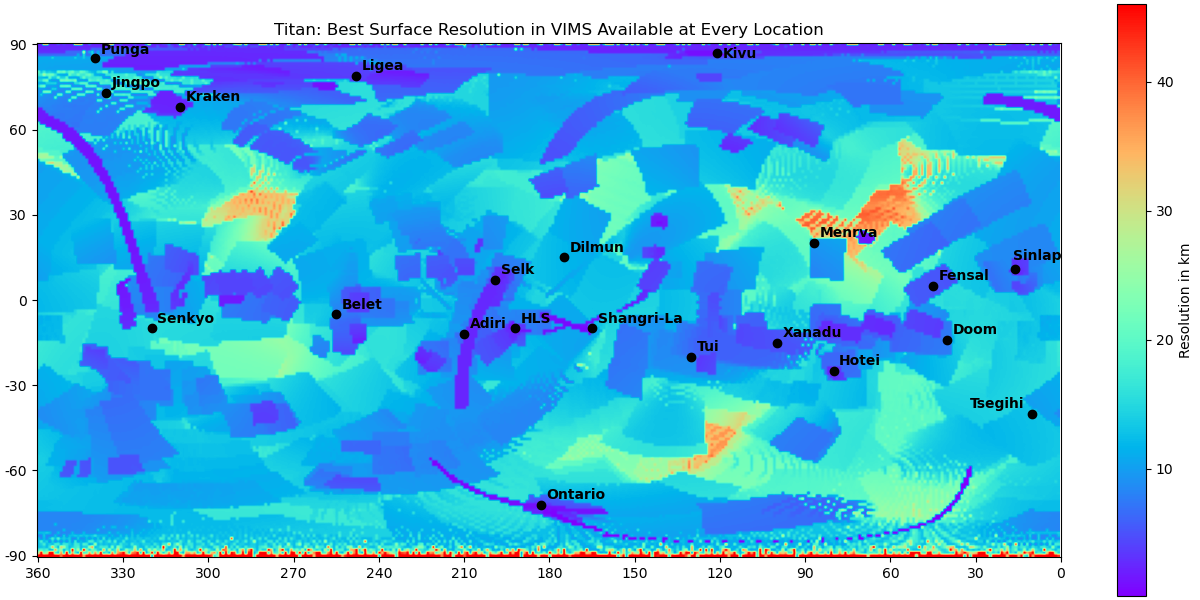

In [6]:
%matplotlib ipympl 

fig, ax = plt.subplots(figsize = (12,6),layout="constrained")
image = ax.imshow(bestRes, cmap = "rainbow")
cb = plt.colorbar(image, label = "Resolution in km")

plt.scatter(360-192, 90+10,color="black")
plt.text(360-192+2, 90+10-2, "HLS", color="black", weight="bold")

plt.scatter(360-183, 90+72,color="black")
plt.text(360-183+2, 90+72-2, "Ontario", color="black", weight="bold")

plt.scatter(360-16, 90-11,color="black")
plt.text(360-16-1, 90-11-3, "Sinlap", color="black", weight="bold")

plt.scatter(360-310, 90-68,color="black")
plt.text(360-310+2, 90-68-2, "Kraken", color="black", weight="bold")

plt.scatter(360-248, 90-79,color="black")
plt.text(360-248+2, 90-79-2, "Ligea", color="black", weight="bold")

plt.scatter(360-340, 90-85,color="black")
plt.text(360-340+2, 90-85-1.6, "Punga", color="black", weight="bold")

plt.scatter(360-336, 90-73,color="black")
plt.text(360-336+2, 90-73-2, "Jingpo", color="black", weight="bold")

plt.scatter(360-121, 90-87,color="black")
plt.text(360-121+2, 90-87+2, "Kivu", color="black", weight="bold")

plt.scatter(360-87, 90-20,color="black")
plt.text(360-87+2, 90-20-2, "Menrva", color="black", weight="bold")

plt.scatter(360-199, 90-7,color="black")
plt.text(360-199+2, 90-7-2, "Selk", color="black", weight="bold")

plt.scatter(360-165, 90+10,color="black")
plt.text(360-165+2, 90+10-2, "Shangri-La", color="black", weight="bold")

plt.scatter(360-10, 90+40,color="black")
plt.text(360-10-22, 90+40-2, "Tsegihi", color="black", weight="bold")

plt.scatter(360-40, 90+14,color="black")
plt.text(360-40+2, 90+14-2, "Doom", color="black", weight="bold")

plt.scatter(360-210, 90+12,color="black")
plt.text(360-210+2, 90+12-2, "Adiri", color="black", weight="bold")

plt.scatter(360-175, 90-15,color="black")
plt.text(360-175+2, 90-15-2, "Dilmun", color="black", weight="bold")

plt.scatter(360-255, 90+5,color="black")
plt.text(360-255+2, 90+5-2, "Belet", color="black", weight="bold")

plt.scatter(360-320, 90+10,color="black")
plt.text(360-320+2, 90+10-2, "Senkyo", color="black", weight="bold")

plt.scatter(360-45, 90-5,color="black")
plt.text(360-45+2, 90-5-2, "Fensal", color="black", weight="bold")

plt.scatter(360-100, 90+15,color="black")
plt.text(360-100+2, 90+15-2, "Xanadu", color="black", weight="bold")

plt.scatter(360-130, 90+20,color="black")
plt.text(360-130+2, 90+20-2, "Tui", color="black", weight="bold")

plt.scatter(360-80, 90+25,color="black")
plt.text(360-80+2, 90+25-2, "Hotei", color="black", weight="bold")

latTicks = [0, 30, 60, 90, 120, 150, 180]
latLabels = ["90", "60", "30", "0", "-30", "-60", "-90"]
lonTicks = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
lonLabels = ["360", "330", "300", "270", "240", "210", "180", "150", "120", "90", "60", "30", "0"]
ax.set_yticks(latTicks)
ax.set_yticklabels(latLabels)
ax.set_xticks(lonTicks)
ax.set_xticklabels(lonLabels)
ax.set(title = "Titan: Best Surface Resolution in VIMS Available at Every Location")

plt.savefig("CubeBestRes.pdf", format="pdf")

In [7]:
%matplotlib ipympl 

#The poles pose a problem, it often looks like they have less data than the others, but really the pixel surface area there is distorted. We can combat this somewhat by dividing through!

cubeNorm = [[0 for x in range(360)] for x in range(181)]

#Will hold the normalized observations: number of observations divided by pixel surface area.
#Let's see if we can find a formula for this...
#Had to do some calculus. IN short, the area element in spherical coordiantes is R^2 sin(phi) dtheta dphi. Integrating it over 
#everything we get that A = R^2 (theta_1 - theta_0) (cos(phi_0) - cos(phi_1)) where theta is lon and phi is lat in RADIANS. 
#BE EVEN MORE CAREFUL: whiel lon doesn't have a reference point that matters so long as the length is the same, lat DOES. 0 in the formula is measured from the POLE
#This means the equation would break if we were trying to measure across the equator, most likely, but fourtunately that is one of our boundaries we don't care about.
#So let's now print the surface area of every pixel. Which is gonna be a bit odd since they rest *on* the points...

R = 2575 #radius of Titan.

lat = 90 #We only need this in reference to lat itself.
#Edges are different, do them separately than the rest. 
#Difference in lon is always the same, replace with number, specifically 1 degree in radians.

areaByLat = []

area = R*R*np.radians(1)*(np.cos(np.radians(0)) - np.cos(np.radians(0.5)))
areaByLat.append([lat, area])
lat = lat - 1

#Situation is symmetrical, so we should be fine!

while (lat > 0):
    area = R*R*np.radians(1)*(np.cos(np.radians(0.5 - lat + 90)) - np.cos(np.radians(1.5 - lat + 90)))
    areaByLat.append([lat, area])
    lat = lat - 1
    
area = R*R*np.radians(1)*(np.cos(np.radians(89.5)) - np.cos(np.radians(90)))*2
areaByLat.append([lat, area])
lat = lat -1

while (lat > -91):
    areaByLat.append([lat, areaByLat[abs(lat+90)][1]])
    lat = lat -1

#And now that we have this, we apply it to our data!
i, j = 0,0
while (i < 360):
    j=0
    while (j < 181):
        scaleFactor = areaByLat[j][1] #Grab the area of the pixels at this latitude...
        cubeNorm[j][i] = cubeNum45[j][i] / scaleFactor #Actual Normalization!
        j = j+1
    i = i+1
    


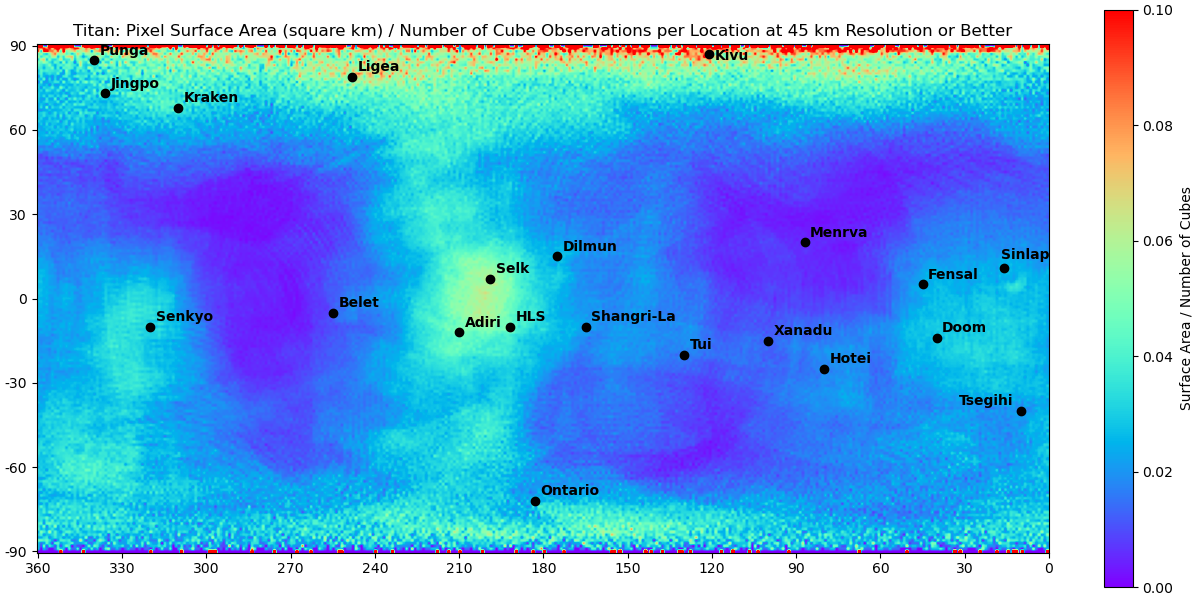

In [8]:
%matplotlib ipympl 

fig, ax = plt.subplots(figsize = (12,6),layout="constrained")
image = ax.imshow(cubeNorm, cmap = "rainbow",vmax=0.1)
cb = plt.colorbar(image, label = "Surface Area / Number of Cubes")

plt.scatter(360-192, 90+10,color="black")
plt.text(360-192+2, 90+10-2, "HLS", color="black", weight="bold")

plt.scatter(360-183, 90+72,color="black")
plt.text(360-183+2, 90+72-2, "Ontario", color="black", weight="bold")

plt.scatter(360-16, 90-11,color="black")
plt.text(360-16-1, 90-11-3, "Sinlap", color="black", weight="bold")

plt.scatter(360-310, 90-68,color="black")
plt.text(360-310+2, 90-68-2, "Kraken", color="black", weight="bold")

plt.scatter(360-248, 90-79,color="black")
plt.text(360-248+2, 90-79-2, "Ligea", color="black", weight="bold")

plt.scatter(360-340, 90-85,color="black")
plt.text(360-340+2, 90-85-1.6, "Punga", color="black", weight="bold")

plt.scatter(360-336, 90-73,color="black")
plt.text(360-336+2, 90-73-2, "Jingpo", color="black", weight="bold")

plt.scatter(360-121, 90-87,color="black")
plt.text(360-121+2, 90-87+2, "Kivu", color="black", weight="bold")

plt.scatter(360-87, 90-20,color="black")
plt.text(360-87+2, 90-20-2, "Menrva", color="black", weight="bold")

plt.scatter(360-199, 90-7,color="black")
plt.text(360-199+2, 90-7-2, "Selk", color="black", weight="bold")

plt.scatter(360-165, 90+10,color="black")
plt.text(360-165+2, 90+10-2, "Shangri-La", color="black", weight="bold")

plt.scatter(360-10, 90+40,color="black")
plt.text(360-10-22, 90+40-2, "Tsegihi", color="black", weight="bold")

plt.scatter(360-40, 90+14,color="black")
plt.text(360-40+2, 90+14-2, "Doom", color="black", weight="bold")

plt.scatter(360-210, 90+12,color="black")
plt.text(360-210+2, 90+12-2, "Adiri", color="black", weight="bold")

plt.scatter(360-175, 90-15,color="black")
plt.text(360-175+2, 90-15-2, "Dilmun", color="black", weight="bold")

plt.scatter(360-255, 90+5,color="black")
plt.text(360-255+2, 90+5-2, "Belet", color="black", weight="bold")

plt.scatter(360-320, 90+10,color="black")
plt.text(360-320+2, 90+10-2, "Senkyo", color="black", weight="bold")

plt.scatter(360-45, 90-5,color="black")
plt.text(360-45+2, 90-5-2, "Fensal", color="black", weight="bold")

plt.scatter(360-100, 90+15,color="black")
plt.text(360-100+2, 90+15-2, "Xanadu", color="black", weight="bold")

plt.scatter(360-130, 90+20,color="black")
plt.text(360-130+2, 90+20-2, "Tui", color="black", weight="bold")

plt.scatter(360-80, 90+25,color="black")
plt.text(360-80+2, 90+25-2, "Hotei", color="black", weight="bold")

latTicks = [0, 30, 60, 90, 120, 150, 180]
latLabels = ["90", "60", "30", "0", "-30", "-60", "-90"]
lonTicks = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
lonLabels = ["360", "330", "300", "270", "240", "210", "180", "150", "120", "90", "60", "30", "0"]
ax.set_yticks(latTicks)
ax.set_yticklabels(latLabels)
ax.set_xticks(lonTicks)
ax.set_xticklabels(lonLabels)
ax.set(title = "Titan: Pixel Surface Area (square km) / Number of Cube Observations per Location at 45 km Resolution or Better")

plt.savefig("CubeNormalizedNum.pdf", format="pdf")

In [9]:
#Now we can read in what we just created over... looks like about six hours. 
#3624 cubes passed the test. Likely because we took a lot at super far distances, or has a bunch of invalid "0" resolution cubes. 
#Read in the file, sort everything into the needed arrays, and then display NUMBER OF CUBES and BEST RESOLUTION maps of Titan.
import matplotlib.pyplot as plt
import csv
import math
import numpy as np
import scipy.misc

cubeList = 'acceptableCubesAnnotated.csv' #Insert file name for SIMULATION DATA here.

cubeNum45Scaled = [[0 for x in range(360)] for x in range(181)]
cubeNum25Scaled = [[0 for x in range(360)] for x in range(181)]
cubeNum15Scaled = [[0 for x in range(360)] for x in range(181)]
cubeNum10Scaled = [[0 for x in range(360)] for x in range(181)]

#We have manually created a series of numbers based on latitude to determine the bin size.
binSize = [360, 30, 20, 15, 12, 10, 8, 6, 6, 5,
           5, 4, 4, 4, 3, 3, 3, 3, 3, 2, 
           2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
           1, # at 0 here 
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
           2, 3, 3, 3, 3, 3, 4, 4, 4, 5, 
           5, 6, 6, 8, 10, 12, 15, 20, 30, 360]


with open(cubeList) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        flags = [[0 for x in range(360)] for x in range(181)] #For checking to make sure we haven't already put this cube's observations into a bin.
        #Needs to be set to zero for EVERY CUBE. Which is why it's here.
        size = len(row) #each row is a cube which may look at several locaitons.
        loc = 1 #The "0" location is just the cube as a whole metadata, which we do not care about.
        while (loc < (size-1)/4): #-1 since there is an extra hanging comma at the end of the line.
            lat = int(row[loc*4])
            lon = int(row[loc*4+1])
            if (lon == 0): lon = 360 #these are the same index. Set to 360 so that when we flip it ends up on index 0.
            minRes = float(row[loc*4+2])
            maxRes = float(row[loc*4+3]) #We actually don't care about this one but might as well read it in anyway.
            if (lat <= 90 and lat >= -90 and lon <= 360 and lon >= 1 and flags[90-lat][360-lon] == 0): #No exterior ones allowed! Most assuredly errors!
                cubeNum45Scaled[90-lat][360-lon] = cubeNum45Scaled[90-lat][360-lon] + 1
                if (minRes <= 10):
                    cubeNum10Scaled[90-lat][360-lon] = cubeNum10Scaled[90-lat][360-lon] + 1
                if (minRes <= 15):
                    cubeNum15Scaled[90-lat][360-lon] = cubeNum15Scaled[90-lat][360-lon] + 1
                if (minRes <= 25):
                    cubeNum25Scaled[90-lat][360-lon] = cubeNum25Scaled[90-lat][360-lon] + 1

                #FLAGS SECTION
                #So here's the issue, some areas need to be extended to multiple pixels, so the values that were just updated may need to be expanded. 
               
                if (binSize[90-lat] == 1): #this is the case where we do nothing but check for wrap around.
                    if (lon == 360): 
                        flags[90-lat][360-lon] = 1 #Don't count the edge twice per cube, that's silly.
                        #Flags are unecessary otherwise, as each pixel only has one bin it can be in, its own.
                elif (binSize[90-lat] == 360): #The other extreme: if we're looking AT a pole. 
                    #In this case, flag everything, but also update everything.
                    k = 0
                    while (k < 360):
                        cubeNum45Scaled[90-lat][k] = cubeNum45Scaled[90-lat][360-lon]
                        cubeNum25Scaled[90-lat][k] = cubeNum25Scaled[90-lat][360-lon]
                        cubeNum15Scaled[90-lat][k] = cubeNum15Scaled[90-lat][360-lon]
                        cubeNum10Scaled[90-lat][k] = cubeNum10Scaled[90-lat][360-lon]
                        flags[90-lat][k] = 1 #This cube can't be used at the pole again! HAH!
                        k=k+1
                        #No need to check for wrap around, the pole is unique. 
                else: #Otherwise we're gonna have to do Bin MagicTM. #THE PROBLEM IS (PROBABLY) HERE.
                    #Step one... find out in which bin we're actually in, finding the index of the first one.
                    k=0
                    saveIndex = 0
                    while (k < 360):
                        if (k > 360-lon):
                            saveIndex = k - binSize[90-lat] #The "greater than" check means we overshot, the previous one was the one we wanted.
                            k = 361 #A signal to break the loop.
                        else: 
                            k = k + binSize[90-lat] #increase in chunks by binSize
                    if (k == 360): saveIndex = 360 - binSize[90-lat] #We're in the last section in this case. 

                    k=0
                    while (k < binSize[90-lat]):
                        #print(90-lat, saveIndex, k)
                        #now go over everything in the bin and make sure it's all updated to the value we just set. 
                        #Yes this is redundant, it overwrites one of the values with itself, but I'm not coding in that extra check.
                        cubeNum45Scaled[90-lat][saveIndex + k] = cubeNum45Scaled[90-lat][360-lon]
                        cubeNum25Scaled[90-lat][saveIndex + k] = cubeNum25Scaled[90-lat][360-lon]
                        cubeNum15Scaled[90-lat][saveIndex + k] = cubeNum15Scaled[90-lat][360-lon]
                        cubeNum10Scaled[90-lat][saveIndex + k] = cubeNum10Scaled[90-lat][360-lon]
                        flags[90-lat][saveIndex + k] = 1
                        k=k+1
                    
            loc = loc+1
        line_count += 1


#plt.savefig("TitanSurfaceMask.pdf", format="pdf", bbox_inches='tight')

[Text(0.5, 1.0, 'TiTaN??')]

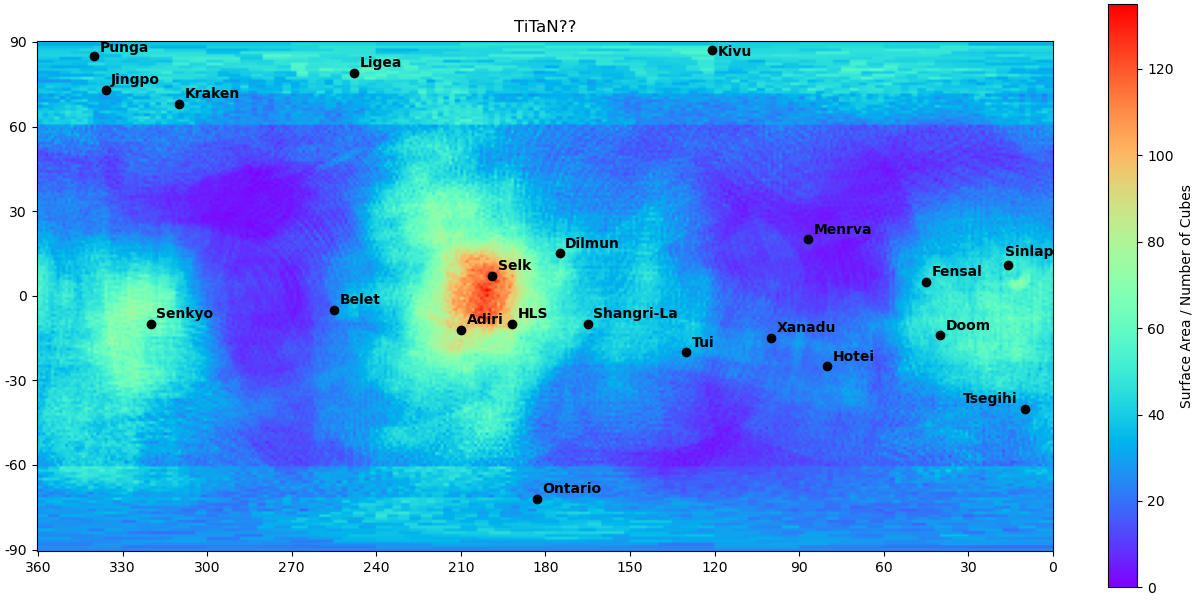

In [13]:
%matplotlib ipympl 

fig, ax = plt.subplots(figsize = (12,6),layout="constrained")
image = ax.imshow(cubeNum45Scaled, cmap = "rainbow")
cb = plt.colorbar(image, label = "Surface Area / Number of Cubes")

plt.scatter(360-192, 90+10,color="black")
plt.text(360-192+2, 90+10-2, "HLS", color="black", weight="bold")

plt.scatter(360-183, 90+72,color="black")
plt.text(360-183+2, 90+72-2, "Ontario", color="black", weight="bold")

plt.scatter(360-16, 90-11,color="black")
plt.text(360-16-1, 90-11-3, "Sinlap", color="black", weight="bold")

plt.scatter(360-310, 90-68,color="black")
plt.text(360-310+2, 90-68-2, "Kraken", color="black", weight="bold")

plt.scatter(360-248, 90-79,color="black")
plt.text(360-248+2, 90-79-2, "Ligea", color="black", weight="bold")

plt.scatter(360-340, 90-85,color="black")
plt.text(360-340+2, 90-85-1.6, "Punga", color="black", weight="bold")

plt.scatter(360-336, 90-73,color="black")
plt.text(360-336+2, 90-73-2, "Jingpo", color="black", weight="bold")

plt.scatter(360-121, 90-87,color="black")
plt.text(360-121+2, 90-87+2, "Kivu", color="black", weight="bold")

plt.scatter(360-87, 90-20,color="black")
plt.text(360-87+2, 90-20-2, "Menrva", color="black", weight="bold")

plt.scatter(360-199, 90-7,color="black")
plt.text(360-199+2, 90-7-2, "Selk", color="black", weight="bold")

plt.scatter(360-165, 90+10,color="black")
plt.text(360-165+2, 90+10-2, "Shangri-La", color="black", weight="bold")

plt.scatter(360-10, 90+40,color="black")
plt.text(360-10-22, 90+40-2, "Tsegihi", color="black", weight="bold")

plt.scatter(360-40, 90+14,color="black")
plt.text(360-40+2, 90+14-2, "Doom", color="black", weight="bold")

plt.scatter(360-210, 90+12,color="black")
plt.text(360-210+2, 90+12-2, "Adiri", color="black", weight="bold")

plt.scatter(360-175, 90-15,color="black")
plt.text(360-175+2, 90-15-2, "Dilmun", color="black", weight="bold")

plt.scatter(360-255, 90+5,color="black")
plt.text(360-255+2, 90+5-2, "Belet", color="black", weight="bold")

plt.scatter(360-320, 90+10,color="black")
plt.text(360-320+2, 90+10-2, "Senkyo", color="black", weight="bold")

plt.scatter(360-45, 90-5,color="black")
plt.text(360-45+2, 90-5-2, "Fensal", color="black", weight="bold")

plt.scatter(360-100, 90+15,color="black")
plt.text(360-100+2, 90+15-2, "Xanadu", color="black", weight="bold")

plt.scatter(360-130, 90+20,color="black")
plt.text(360-130+2, 90+20-2, "Tui", color="black", weight="bold")

plt.scatter(360-80, 90+25,color="black")
plt.text(360-80+2, 90+25-2, "Hotei", color="black", weight="bold")

latTicks = [0, 30, 60, 90, 120, 150, 180]
latLabels = ["90", "60", "30", "0", "-30", "-60", "-90"]
lonTicks = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
lonLabels = ["360", "330", "300", "270", "240", "210", "180", "150", "120", "90", "60", "30", "0"]
ax.set_yticks(latTicks)
ax.set_yticklabels(latLabels)
ax.set_xticks(lonTicks)
ax.set_xticklabels(lonLabels)
ax.set(title = "TiTaN??")

In [1]:
#Now we can read in what we just created over... looks like about six hours. 
#3624 cubes passed the test. Likely because we took a lot at super far distances, or has a bunch of invalid "0" resolution cubes. 
#Read in the file, sort everything into the needed arrays, and then display NUMBER OF CUBES and BEST RESOLUTION maps of Titan.
import matplotlib.pyplot as plt
import csv
import math
import numpy as np
import scipy.misc

cubeList = 'acceptableCubesAnnotated.csv' #Insert file name for SIMULATION DATA here.

LAT = -85
LON = 148
#all caps to differentiate from in-cube lat and lon.

while (LAT > -91):
    while (LON > 0):

        #We need data for every location.
        gatheredCubes = [] 
        gatheredCubes.append([LAT,LON])
        #Now we look through EEEEVERY line in the cubeList file 

        with open(cubeList) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            line_count = 0
            for row in csv_reader:
                flyby = row[0]
                cubeName = row[1]
                size = len(row) #each row is a cube which may look at several locaitons.
                loc = 1 #The "0" location is just the cube as a whole metadata, which we do not care about.
                while (loc < (size-1)/4): #-1 since there is an extra hanging comma at the end of the line.
                    lat = int(row[loc*4])
                    lon = int(row[loc*4+1])
                    if (lon == 0): lon = 360 #these are the same index. Set to 360 so that when we flip it ends up on index 0.
                    if (lat == LAT and lon == LON):
                        gatheredCubes.append([flyby, cubeName]) #Don't count the edge twice per cube, that's silly.
                        loc = (size-1)/4
                    loc = loc+1
                line_count += 1

        with open("acceptableCubesAnnotatedByLocation.csv", 'a') as dataEntry: #w for write
            dataEntry.write(str(gatheredCubes) + "\n")
        
        LON = LON-1
    LAT = LAT-1
    LON = 360

#plt.savefig("TitanSurfaceMask.pdf", format="pdf", bbox_inches='tight')